<a href="https://colab.research.google.com/github/danort92/Face-Detection/blob/main/FaceFinder_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FaceFinder - A Face Detection Model**

In this notebook I am going to develop a Face Detection Model given a photo as input. I won't use pre-trained models, but will create my own from scratch.

I will use imgaug library to manage images and scikit-learn functions

In [1]:
!pip install opencv-python
!pip install imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
from PIL import Image
import glob
import collections
import pickle
import time

import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmenters import Fliplr, Flipud, Affine
from itertools import chain
from skimage import data, color, feature
import skimage.data
from skimage.transform import resize

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import GridSearchCV

In [3]:
#say no to warnings!
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) 

## IMPORT DATA

I will train the model using positive and negative images from Caltech dataset. It contains 6713 positive (w/ faces) and 275 negative (w/o faces) images.

In [4]:
def create_img_array(path, patch_size=(36,36)):
    """
    FUNC: creation of an array of grey images with predefined size
    ARGS: 
        - path: string; the path of images set
        - patch_size: (2,) tuple; the pixel dimensionality of images 
          (default=(36,36), that's the dimensions of Caltech_CropFaces positive images imported. 
          With other sets you can change it to other dimensions)
    RETURN:
        - img_array: (N,2) ndarray; N is the number of images and each row represents width and height.
    """
    img_array=[]
    for file in path:
        image = cv2.imread (file)
        image = cv2.resize(image, dsize=patch_size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        img_array.append(image)
    return img_array

In [5]:
!git clone https://github.com/danort92/Face-Detection.git
pos_path="/Face-Detection/sets/train_positive_set/Caltech_CropFaces"
neg_path="/Face-Detection/sets/train_negative_set"
pos_set=create_img_array(glob.glob (os.getcwd() + pos_path + "/*.jpg"))
neg_set=create_img_array(glob.glob (os.getcwd() + neg_path + "/*.jpg"))

Cloning into 'Face-Detection'...
remote: Enumerating objects: 7103, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 7103 (delta 0), reused 5 (delta 0), pack-reused 7093
Receiving objects: 100% (7103/7103), 49.09 MiB | 33.31 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [6]:
#function to show a subset of the images array previously created
def show_img_subplot(img_set):
    fig, ax = plt.subplots(4, 8, figsize=(10, 4))
    n_images=np.array(img_set).shape[0]
    for i, axi in enumerate(ax.flat):
        k=np.random.choice(n_images,1)[0]
        axi.imshow(img_set[k], cmap='gray')
        axi.axis('off')    

## DATA AUGMENTATION

Dataset is augmented with slightly modified images. Negative pics are horizontally and vertically flipped, rotated and cropped. Positive pics are just mirrored (applying the same modifies as done for the negative set I've seen to be linked to many false positives, so I preferred only the less invasive modification)

In [7]:
#original script found on https://imgaug.readthedocs.io/ and slightly modified in order to perform data augmentation

def img_neg_augmentation(img_set,neg_k=1):
    """
    FUNC: Data augmentation through different techniques (horiziontal flip, vertical flip, rotation and shear)
          Images are randomly chosen through random choice of index
    ARGS: 
        - img_set: (N,2) ndarray; N is the number of negative images and each row represents width and height.
        - neg_k:  constant, multiplier of images randomly chosen from the original set
    RETURN:
        - aug_set: (M,2) ndarray; M is the number of negative images (M>N) and each row represents width and height
    """

    n_images=np.array(img_set).shape[0]
    aug_set=[]
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    for i in range(1,int(neg_k/4*n_images)):
        r=np.random.choice(n_images,1)[0]
        
        hflip= iaa.Fliplr(p=0.6)
        aug_hor_image= hflip.augment_image(img_set[r])
        aug_set.append(aug_hor_image)
        
        vflip= iaa.Flipud(p=0.2)
        aug_ver_image= vflip.augment_image(img_set[r])
        aug_set.append(aug_ver_image)
        
        aff = sometimes(iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                    rotate=(-25, 25),
                    shear=(-30, 30),
                    order=[0, 1],
                    cval=(0, 255),
                    mode=ia.ALL))
        aug_aff_image= aff.augment_image(img_set[r])
        aug_set.append(aug_aff_image)
        
        crop=sometimes(iaa.Crop(percent=(0, 0.1)))
        aug_crop_image= crop.augment_image(img_set[r])
        aug_set.append(aug_crop_image)

    return aug_set

In [8]:
#original script found on https://imgaug.readthedocs.io/ and slightly modified in order to perform data augmentation

def img_pos_augmentation(img_set,pos_k):
    """
    FUNC: Data augmentation only through horiziontal flip 
          (applying the same techniques used for negative set there would be many more false positives)
          Images are randomly chosen through random choice of index
    ARGS: 
        - img_set: (N,2) ndarray; N is the number of positive images and each row represents width and height.
        - pos_k:  constant, multiplier of images randomly chosen from the original set
    RETURN:
        - aug_set: (M,2) ndarray; M is the number of positive images (M>N) and each row represents width and height
    """

    n_images=np.array(img_set).shape[0]
    aug_set=[]
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    for i in range(1,int(pos_k*n_images)):
        r=np.random.choice(n_images,1)[0]
        
        hflip= iaa.Fliplr(p=0.6)
        aug_hor_image= hflip.augment_image(img_set[r])
        aug_set.append(aug_hor_image)
        
    return aug_set

## SVM MODEL

A linear Support Vector Machine model is used. Hyperparameters are optimized through the script found on https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV. It iterates to find the best estimators for the binary classification model GridSearchCV

In [9]:
def print_dataframe(filtered_cv_results):
    """Pretty print for filtered dataframe"""
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_precision"],
        filtered_cv_results["std_test_precision"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()


def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.

    The strategy defined here is to filter-out all results below a precision threshold
    of 0.97, rank the remaining by recall and keep all models with one standard
    deviation of the best by recall. Once these models are selected, we can select the
    fastest model to predict.

    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.

    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    # print the info about the grid-search for the different scores
    precision_threshold = 0.97

    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print_dataframe(cv_results_)

    # Filter-out all results below the threshold
    high_precision_cv_results = cv_results_[
        cv_results_["mean_test_precision"] > precision_threshold
    ]

    print(f"Models with a precision higher than {precision_threshold}:")
    print_dataframe(high_precision_cv_results)

    high_precision_cv_results = high_precision_cv_results[
        [
            "mean_score_time",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_precision",
            "std_test_precision",
            "rank_test_recall",
            "rank_test_precision",
            "params",
        ]
    ]

    # Select the most performant models in terms of recall
    # (within 1 sigma from the best)
    best_recall_std = high_precision_cv_results["mean_test_recall"].std()
    best_recall = high_precision_cv_results["mean_test_recall"].max()
    best_recall_threshold = best_recall - best_recall_std

    high_recall_cv_results = high_precision_cv_results[
        high_precision_cv_results["mean_test_recall"] > best_recall_threshold
    ]
    print(
        "Out of the previously selected high precision models, we keep all the\n"
        "the models within one standard deviation of the highest recall model:"
    )
    print_dataframe(high_recall_cv_results)

    # From the best candidates, select the fastest model to predict
    fastest_top_recall_high_precision_index = high_recall_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on precision and recall.\n"
        "Its scoring time is:\n\n"
        f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
    )

    return fastest_top_recall_high_precision_index

Transformation of images in HOG vectors is performed, because HOG relies on the property of objects within an image to possess the distribution of intensity gradients or edge directions. 
              Gradients are calculated within an image per patch. A patch is considered as a pixel grid in which gradients 
              are constituted from the magnitude and direction of change in the intensities of the pixel within the patch.

In [10]:
def train_classifier(pos_set,neg_set,pixel_per_cell=(6,6)):

    """
    FUNC: 1 - The train features and labels are created from predefined positive and negative sets.
          2 - The images are transformed in vectors through HOG feature from skimage library
          3 - A Linear Support Vector Classification model is then trained in order to optimize precision and recall through cross-validation.
    ARGS:
        - pos_set: (N,2) ndarray; N is the number of positive images and each row is width and height.
        - neg_set: (N,2) ndarray; N is the number of negative images and each row is width and height.
    RETURN:
        - model: the model fitted with best found estimators 
    """

    X_train = np.array([feature.hog(im, pixels_per_cell=pixel_per_cell)
                        for im in chain(pos_set,
                                        neg_set)])
    y_train = np.zeros(X_train.shape[0])
    y_train[:np.shape(pos_set)[0]] = 1
    
    scoring = ['precision','recall']
    grid = GridSearchCV(LinearSVC(random_state=1), 
                        {"C": [0.001,0.0025,0.005,0.01,0.025,0.05]},
                        scoring=scoring,
                        verbose=2,
                       refit=refit_strategy)
    grid.fit(X_train, y_train)
    
    model = grid.best_estimator_
    model.fit(X_train, y_train)
    
    return model

## TESTING

During the testing phase a sliding window approach is used to slide on the image given a fixed step and find the patches' confidence. The patches with confidence higher than a positive threshold are considered as bounding boxes with enough probability to contain a face. Overlapping bounding boxes with lower confidences are then suppressed. Patches with confidence lower than a negative threshold, instead, have a high probability to not contain any faces and are saved for a subsequent hard mining phase where they aer used to manually boost the model

In [11]:
def non_max_supr_bbox(bboxes, confidences, img_size):

    """
    FUNC: high confidence detections suppress all overlapping detections
        (including detections at other scales). Detections can partially
        overlap, but the center of one detection can not be within another
        detection.
    ARGS:
        - bboxes: (N,4) ndarray; N is the number of non-overlapping detections,
                  and each row is [x_min, y_min, x_max, y_max].
        - confidences: (N,1) ndarray; Confidence of each detection after final
                  cascade node.
        - img_size: (2,) list; width and height of the image.
    RETURN:
        - is_valid_bbox: (N,1) bool ndarray; indicating valid bounding boxes.
    """

    #Truncate bounding boxes to image dimensions
    x_out_of_bounds=bboxes[:,2] > img_size[1]  #xmax greater than x dimension
    y_out_of_bounds=bboxes[:,3] > img_size[0]  #ymax greater than y dimension
    bboxes[x_out_of_bounds,2]=img_size[1]
    bboxes[y_out_of_bounds,3]=img_size[0]

    num_detections=confidences.shape[0]

    #higher confidence detections get priority
    ind=np.argsort(-confidences, axis=0).ravel()
    bboxes=bboxes[ind,:]

    #indicator for whether each bbox will be accepted or suppressed
    is_valid_bbox=np.zeros((num_detections,1),dtype=np.bool)
    for i in range(num_detections):
        cur_bb=bboxes[i,:]
        cur_bb_is_valid=True

        for j in np.where(is_valid_bbox)[0]:
            prev_bb=bboxes[j,:]
            bi=[max(cur_bb[0], prev_bb[0]),
                max(cur_bb[1], prev_bb[1]),
                min(cur_bb[2], prev_bb[2]),
                min(cur_bb[3], prev_bb[3])]
            iw=bi[2]-bi[0]+1
            ih=bi[3]-bi[1]+1

            if iw>0 and ih>0:
                #compute overlap as area of intersection / area of union
                ua=(cur_bb[2] - cur_bb[0] + 1) * (cur_bb[3] - cur_bb[1] + 1) + \
                     (prev_bb[2] - prev_bb[0] + 1) * (prev_bb[3] - prev_bb[1] + 1) - \
                     iw * ih
                ov = iw * ih / ua

                #if the less confident detection overlaps too much with the previous detection
                if ov>0.2:
                    cur_bb_is_valid=False

                center_coord=[(cur_bb[0] + cur_bb[2]) / 2, (cur_bb[1] + cur_bb[3]) / 2]
                if (center_coord[0] > prev_bb[0]) and (center_coord[0] < prev_bb[2]) and \
                        (center_coord[1] > prev_bb[1]) and (center_coord[1] < prev_bb[3]):
                    cur_bb_is_valid=False

        is_valid_bbox[i]=cur_bb_is_valid

    #This statement returns the logical array 'is_valid_bbox' back to the order
    #of the input bboxes and confidences
    reverse_map=np.zeros((num_detections,), dtype=np.int)
    reverse_map[ind]=np.arange(num_detections)
    is_valid_bbox=is_valid_bbox[reverse_map,:]

    return is_valid_bbox

In [12]:
def sliding_window(path, patch_size=(36,36), pixel_per_cell=(6,6), step=3, p_threshold=1, n_threshold=-0.5, downsample=0.8, verbose=False):

    """
    FUNC: a patch of predefined size slides on the image with a specific step.
          1 - For each step i) the image is transformed through Histogram Of Gradients (HOG) function
              and ii) a confidence level is calculated based on the trained model. 
          2 - If the conficence is higher than a predefined threshold the patch is kept because it has 
              a relatively high probability to contain a face. A negative threshold is also set to keep patch with a low confidence
              (to eventually perform a negative hard mining, including those pathces in the train set manually boost the model)
          3 - The previous points are repeated at different scales (there could be faces with different dimensions inside the image) 
    ARGS:
        - path: string - the path of the image
        - patch_size: (2,) tuple; pixel dimensions of the patch (Width,Height)
        - step: constant; pixel step between two condecutive patches and defining the sliding window mechanism
        - p_threshold: constant; threshold for high confidence patches (default=1, the lower the higher the risk of false positives)
        - n_threshold: constant; threshold for low confidence patches (default=-0.5, the lower )
        - downsample: constant; the parameter defines the quantity the image is scaled after each loop
        - verbose: boolean; shows some interesting parameters (default=False)  
    RETURN:
        - plt.show(): plot of the image together with the detected bounding boxes
    """
    
    img_name=os.listdir(path)
    
    bboxes = np.zeros([0, 4])
    confidences = np.zeros([0, 1])
    
    hard_neg_set=[]
    k=0
     
    img = cv2.imread(os.path.join(path, img_name[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #process starts from an initial scale defined by this ratio
    #because i) there would be much more false positives and ii) no camera gets to detected very small faces in an image
    scale_factor=4*patch_size[0]/min(img.shape[0],img.shape[1])
    
    W, H = (int(s) for s in patch_size)
    print("------------------------------------------")
    print("Detection STARTED...\n")
    
    while min(img.shape[0],img.shape[1])*scale_factor >= patch_size[0]:
    
        img_re=resize(img, (int(img.shape[0]*scale_factor), int(img.shape[1]*scale_factor)))
        
        
        for i in range(0, img_re.shape[0] - W, step):
            for j in range(0, img_re.shape[1] - H, step):
                  
                patch = img_re[i:i + W, j:j + H]
                patch_hog = feature.hog(patch, pixels_per_cell=pixel_per_cell)
            
                confidence = model.decision_function(patch_hog.reshape(1, -1))
                if confidence>=p_threshold:
                    
                    x_min = j/scale_factor
                    y_min = i/scale_factor
                    x_max = (j+W)/scale_factor
                    y_max = (i+H)/scale_factor

                    bboxes = np.concatenate((bboxes, [[x_min, y_min, x_max, y_max]]), 0)
                    confidences = np.concatenate((confidences, [confidence]), 0)

                elif confidence<n_threshold:
                    hard_neg_set.append(patch)
        if verbose:
          print(f"{k+1}° loop completed --> Scale factor: {scale_factor*100:.2f}%")
           
        k+=1          
        scale_factor = scale_factor * downsample
        
    #added to remove bounding boxes overlapping each others, with preference to higher confidence
    is_maximum = non_max_supr_bbox(bboxes, confidences, img.shape)

    bboxes = bboxes[is_maximum[:, 0], :]
    confidences = confidences[is_maximum[:, 0], :] 
    print("\nDetection COMPLETED!")
    print("------------------------------------------\n")
    print(f"Bounding boxes found: {len(bboxes)}\n") 
    return bboxes, confidences, hard_neg_set

In [13]:
# function that plots images with corresponding bounding boxes
def show_bboxes(path,bboxes):

    """
    FUNC: shows high confidence bounding boxes after sliding window algorithm 
          and suppression of lower confidence overlapping bounding boxes
          if there are no detected bounding boxes the function prints that no faces have been detected, 
          otherwise it shows how many bounding boxes have been found and their coordinates 
    ARGS:
        - path: string - the path of the image
        - bboxes: (N,4) ndarray; N is the number of non-overlapping detections,
                  and each row is [x_min, y_min, x_max, y_max]
    RETURN:
        - plt.show(): plot of the image together with the detected bounding boxes
    """
    
    img_name=os.listdir(path)
    n_bb=len(bboxes)
        
    fig, ax = plt.subplots()
    img = cv2.imread(os.path.join(path, img_name[0]))
    img = color.rgb2gray(img)
    plt.imshow(img, cmap='gray')
    plt.axis('on')
    
    if n_bb!=0: 
        print(f"List of bounding boxes coordinates (x_min, y_min, x_max, y_max): \n")
       
        for i in range(n_bb):
                print(f"{i+1} - ({bboxes[i][0]:.2f}, {bboxes[i][1]:.2f}, {bboxes[i][2]:.2f}, {bboxes[i][3]:.2f})")
                ax.add_patch(plt.Rectangle((bboxes[i][0],bboxes[i][1]), 
                                        bboxes[i][2]-bboxes[i][0], bboxes[i][3]-bboxes[i][1], 
                                        edgecolor='red',alpha=0.3, lw=2, facecolor='none'))
                ax.text(bboxes[i][0], bboxes[i][1], 
                          str(i+1), ha='left', va='top',color="red")   
    else:
        print("No bounding boxes found! Image without faces...")
    print("\n")

    return plt.show()

## HARD MINING

In [22]:
#function which defines the hard mining method, where patches with a not high enough confidence 
#are added to the augmented negative set
def hard_negative_mining(hard_neg_set,neg_set,pos_set, n_hard_mined=5000):

    """
    FUNC: takes a defined number of npatches with confidences lower than a defined threshold, add them to the negative images set 
          and re-train the model in order to reduce false positive detections 
          *** Use only in presence of many false positives, since it's a bit time consuming!
    ARGS:
        - hard_neg_set: (M,2) ndarray; M is the number of patches with confidence lower than a negative threshold 
                        and each row is width and height
        - neg_set: (N,2) ndarray; N is the number of negative images and each row is width and height
        - pos_set: (P,2) ndarray; P is the number of positive images and each row is width and height
        - n_hard_mined: constant; number of patches used for hard mining

    RETURN:

        - neg_set: (K,2) ndarray; K=N+n*M is the number of negative images plus slected nageative patches
                   and each row is width and height
    """

    n_hard_neg=np.array(hard_neg_set).shape[0]
    hard_neg_subset=[]
    i=0
    
    while i < n_hard_mined:
        k=np.random.choice(n_hard_neg,1)[0]
        hard_neg_subset.append(hard_neg_set[k])
        i+=1

    neg_set=np.concatenate((neg_set, hard_neg_subset))
    print("\nHard negative mining COMPLETED!")
    print("----------------------------------------------------------------------------------------------------------\n")

    return neg_set

## FACEFINDER CLASS DEFINITION

In [25]:
class FaceFinder:

  """
  CLASS: face detection of faces inside a picture provided as input

  ATTRIBUTES:
        - pos_k: constant; multiplier factor for data augmentation of positive images dataset
        - neg_k: constant; multiplier factor for data augmentation of negative images dataset
        - filename: str; path where the trained model will be saved
        - URL_image: str, URL link of the image om which the face detection will be performed
  RETURN:
        - model: (TO BE USED BY SAVE_MODEL AND hard_mining METHODS) 
                  the model fitted with best found estimators 
        - aug_neg_set: (TO BE USED BY hard_mining METHOD) 
                        N is the number of negative images and each row is width and height
        - face detection plot: plot of the image together with the detected bounding boxes
        - hard_neg_set: (M,2) ndarray; (TO BE USED BY hard_mining METHOD) 
                         M is the number of patches with confidence lower than a negative threshold and each row is width and height

  """


  def __init__(self, pos_k, neg_k, filename, URL_image):
      self.pos_k=pos_k
      self.neg_k=neg_k
      self.filename=filename
      self.URL_image=URL_image


  def train(self):
      
      aug_pos_set=img_pos_augmentation(pos_set,self.pos_k)
      aug_neg_set=img_neg_augmentation(neg_set,self.neg_k)
      model=train_classifier(aug_pos_set,aug_neg_set)

      return model, aug_neg_set
  
  
  def save_model(self, do_save=False):
      self.do_save=do_save
      if self.do_save:
        pickle.dump(model, open(self.filename, 'wb'))
      

  
  def load_model(self, do_load=False):
      self.do_load=do_load
      if self.do_load:
        model = pickle.load(open(self.filename, 'rb'))
      


  def detect(self):

      path="test"
      URL_image=self.URL_image
      os.system('wget %s' %URL_image)
      !mkdir test
      !mv *.jpg test/
      bboxes, confidences, hard_neg_set=sliding_window(path,verbose=True)
      face_detection_plot=show_bboxes(path,bboxes)

      return face_detection_plot, hard_neg_set

       
  def hard_mining(self, hard_neg_set, aug_neg_set, do_mining=False):

    """
    ATTRIBUTES:
          -hard_neg_set: (M,2) ndarray; (RETURN VALUE OF detect METHOD) 
                                        M is the number of patches with confidence lower than a negative threshold and each row is width and height
          - aug_neg_set: (N,2) ndarray; (RETURN VALUE OF train METHOD) 
                                        N is the number of negative images and each row is width and height
          - do_mining: boolean; if hard_mining is desidered it's valued True and the method is run
    """

    self.hard_neg_set=hard_neg_set
    self.aug_neg_set=aug_neg_set
    self.do_mining=do_mining

    if self.do_mining:
      aug_pos_set=img_pos_augmentation(pos_set,self.pos_k)
      aug_neg_set=hard_negative_mining(self.hard_neg_set,self.aug_neg_set,aug_pos_set)
      model=train_classifier(aug_pos_set,aug_neg_set)
      self.detect()
      print("\nHard negative mining STARTED!")
      print("----------------------------------------------------------------------------------------------------------\n")
    else:
      print("\nHard negative mining NOT performed")
        
      
      



## RUNNING CODE

The dataset used to train the model will be the Caltech dataset, containing respectively: 
6713 positive images (with at least a face), with size (36,36)
274 negative images (with no faces), with size (36,36)

---------------------------------------------------------------------------------------------------------
Do you want to perform a data augmentation on the train dataset (it may help in improving detection)? [yes/press any key for no]: no
Do you want to save the trained model for future use?: yes
Insert the path where the model will be saved: model.sav
Insert the URL link for the image for which you want to detect faces: https://static01.nyt.com/images/2020/11/19/us/artificial-intelligence-fake-people-faces-promo-1605818328743/artificial-intelligence-fake-people-faces-promo-1605818328743-superJumbo-v2.jpg
Do you want to perform an hard negative mining (it may improve the detection reducing false positives)?: no
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END 

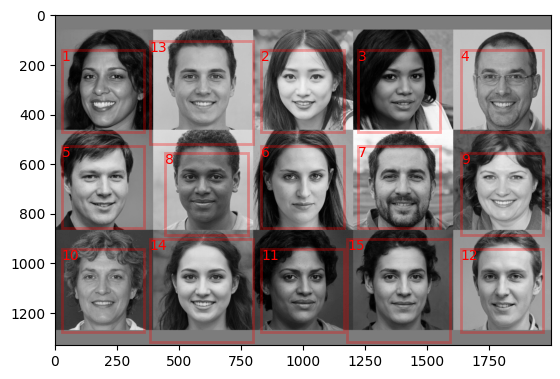


Hard negative mining NOT performed
Do you want to performed detection on another image? [yes/press any key for no]: yes
Do you want to perform a data augmentation on the train dataset (it may help in improving detection)? [yes/press any key for no]: no
Do you want to save the trained model for future use?: no
Do you want to load an already trained model?: yes
Insert the path where the model is saved: model.sav
Insert the URL link for the image for which you want to detect faces: https://static01.nyt.com/images/2020/11/19/us/artificial-intelligence-fake-people-faces-promo-1605818328743/artificial-intelligence-fake-people-faces-promo-1605818328743-superJumbo-v2.jpg
Do you want to perform an hard negative mining (it may improve the detection reducing false positives)?: no
Model has not been loaded
Model has not been saved
mkdir: cannot create directory ‘test’: File exists
------------------------------------------
Detection STARTED...

1° loop completed --> Scale factor: 10.82%
2° loop c

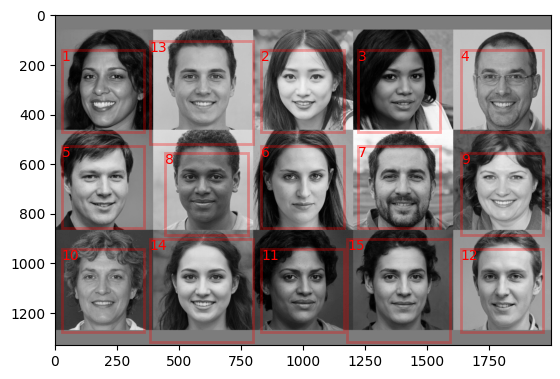


Hard negative mining NOT performed
Do you want to performed detection on another image? [yes/press any key for no]: no


In [34]:
print("The dataset used to train the model will be the Caltech dataset, containing respectively: ")
print(f"{np.array(pos_set).shape[0]} positive images (with at least a face), with size ({np.array(pos_set).shape[1]},{np.array(pos_set).shape[2]})")
print(f"{np.array(neg_set).shape[0]} negative images (with no faces), with size ({np.array(neg_set).shape[1]},{np.array(neg_set).shape[2]})")
print("\n---------------------------------------------------------------------------------------------------------")

keep_going=""
i=0
while str(keep_going.lower()) !="no":

  aug=input("Do you want to perform a data augmentation on the train dataset (it may help in improving detection)? [yes/press any key for no]: ")
  if aug.lower()== "yes":
    pos_k=int(input("Insert multiplier factor for data augmentation of positive dataset: "))
    neg_k=int(input("Insert multiplier factor for data augmentation of negative dataset: "))
  else:
    pos_k=1
    neg_k=1

  do_save=input("Do you want to save the trained model for future use?: ")
  if do_save.lower()=="yes":
    do_save=True
    filename=input("Insert the path where the model will be saved: ")
  else:
    do_save=False

  do_load=False
  if i>0:
    do_load=input("Do you want to load an already trained model?: ")
    if do_load.lower()=="yes":
      do_load=True
      filename=input("Insert the path where the model is saved: ")
    else:
      do_load=False

  URL_image=input("Insert the URL link for the image for which you want to detect faces: ")

  do_mining=input("Do you want to perform an hard negative mining (it may improve the detection reducing false positives)?: ")
  if do_mining.lower()=="yes":
    do_mining=True
  else:
    do_mining=False

  print("\n----------------------------------------------------------------------------------------------------------\n")
  time.sleep(2)
  print("3")
  time.sleep(1)
  print("2")
  time.sleep(1)
  print("1")
  time.sleep(1)
  print("STARTING...\n")
  time.sleep(2)




  face_finder = FaceFinder(pos_k, neg_k, filename, URL_image)
  if do_load==False:
    model, aug_neg_set = face_finder.train()
  else:
    face_finder.load_model()
  face_finder.save_model()
  _, hard_neg_set = face_finder.detect()
  face_finder.hard_mining(hard_neg_set, aug_neg_set, do_mining)

  time.sleep(2)
  keep_going=input("Do you want to performed detection on another image? [Press any key for yes/no]: ")
  i+=1